#Coin Detection in Mario Maps (Template Matching)


This notebook detects coins in Mario maps using **template matching** with three similarity measures:

- **SAD** — Sum of Absolute Differences  
- **SSD** — Sum of Squared Differences  
- **ZNCC** — Zero-mean Normalized Cross-Correlation  


## How to run

1. Place all `mario-bonusarea-*.png` images in the same folder as this notebook (or update `DATA_DIR` accordingly).
2. Run the notebook from top to bottom.
3. The coin template is cropped **during runtime** from a selected Mario map.



## Mapping to the assignment requirements

**1) Smart coin cropping (pre-processing)**  
A single clear coin is selected from a map and cropped tightly (minimal background). Optional contrast enhancement may be applied.

**2) Template matching methods**  
SAD, SSD, and ZNCC are implemented and applied to all maps. Detected coins are marked visually.

**3) Evaluation table**  
A compact detection table is produced.

#**Final Results Summary:**
Both **SSD** and **ZNCC** achieved perfect detection results across all maps.
Since SSD provides the same accuracy with lower computational complexity,
it is the preferred method in this specific experiment.**

**SAD** performed well in most cases but failed in a small number of challenging images.**
These failures can be attributed to its sensitivity to lighting and contrast variations,
which is a known limitation of difference-based methods.



---





## 0. Environment setup

The required libraries are imported and configuration variables are defined.


In [17]:
# Imports
import cv2
import numpy as np
import matplotlib.pyplot as plt

FIGSIZE = (8, 8)


In [18]:

# Visualization helper
def plot_im(img: np.ndarray, title: str = "") -> None:
    """
    Display an image in a consistent way.
    Supports grayscale (2D) and RGB (3D) images.
    """
    plt.figure(figsize=FIGSIZE)
    if img.ndim == 2:
        plt.imshow(img, cmap="gray")
    else:
        plt.imshow(img)
    plt.title(title)
    plt.xticks([]); plt.yticks([])
    plt.show()


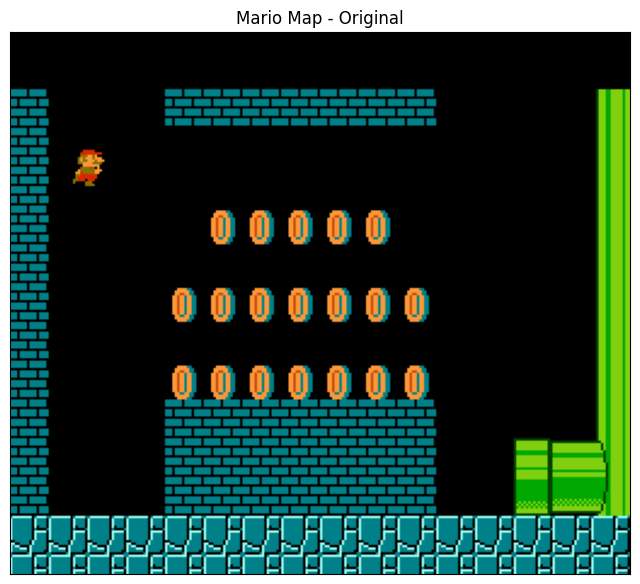

Map shape: (224, 256, 3)


In [19]:
# [Window 3] Load one Mario map (RGB)
def load_map_rgb(map_filename: str) -> np.ndarray:
    map_bgr = cv2.imread(map_filename)
    if map_bgr is None:
        raise FileNotFoundError(f"Could not read image: {map_filename}")
    map_rgb = cv2.cvtColor(map_bgr, cv2.COLOR_BGR2RGB)
    return map_rgb

map_rgb = load_map_rgb("mario-bonusarea-a.png")
plot_im(map_rgb, "Mario Map - Original")
print("Map shape:", map_rgb.shape)


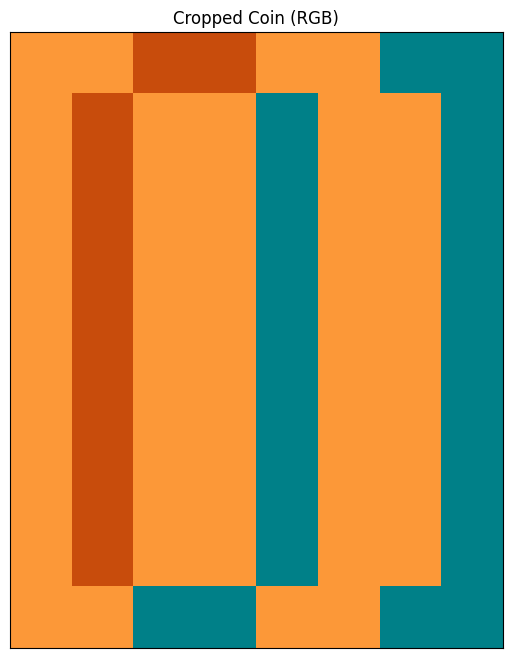

Coin template shape: (10, 8, 3)


In [20]:
# [Window 4] Crop coin template (same coordinates)
def crop_template(map_rgb: np.ndarray, y1: int, y2: int, x1: int, x2: int) -> np.ndarray:
    return map_rgb[y1:y2, x1:x2]

# Same crop values as in the notebook
y1, y2 = 140, 150   # rows (top:bottom)
x1, x2 = 100, 108    # cols (left:right)

coin_rgb = crop_template(map_rgb, y1, y2, x1, x2)
plot_im(coin_rgb, "Cropped Coin (RGB)")
print("Coin template shape:", coin_rgb.shape)


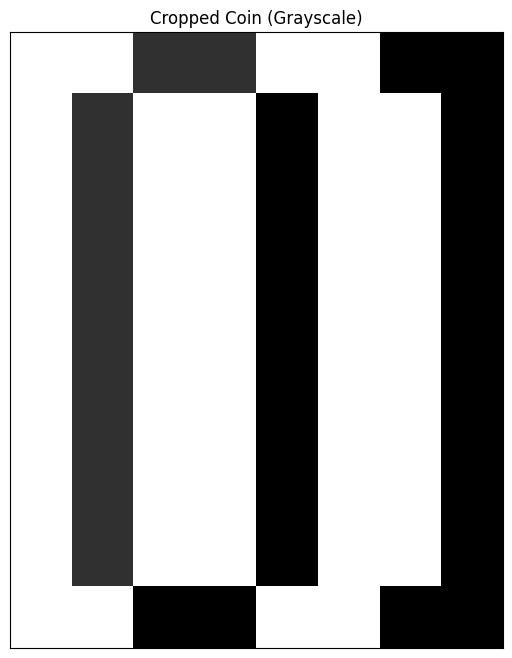

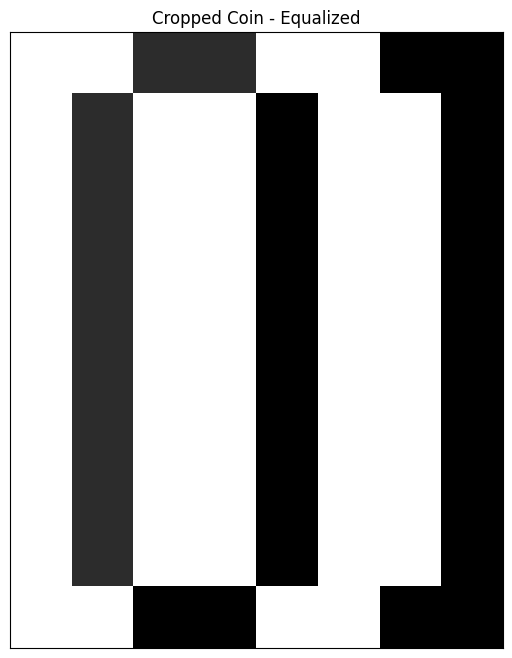

In [21]:

# Template preprocessing (grayscale + equalize)
def preprocess_template(coin_rgb: np.ndarray) -> np.ndarray:
    coin_gray = cv2.cvtColor(coin_rgb, cv2.COLOR_RGB2GRAY)
    coin_eq = cv2.equalizeHist(coin_gray)
    return coin_eq

coin_gray = cv2.cvtColor(coin_rgb, cv2.COLOR_RGB2GRAY)
plot_im(coin_gray, "Cropped Coin (Grayscale)")

coin_template = preprocess_template(coin_rgb)
plot_im(coin_template, "Cropped Coin - Equalized")


## 2. Template matching methods

Each method slides the template over the grayscale map and computes a score per location:

- **SAD / SSD:** lower score → better match (difference-based)
- **ZNCC:** higher score → better match (normalized correlation)

For consistent peak selection across methods, raw scores can be converted to a **similarity map** where higher is better.


In [22]:

# [Window 6] Matching scores: SAD / SSD / ZNCC (same logic)
def compute_match_scores(gray_img: np.ndarray, template: np.ndarray, method: str = "SAD") -> np.ndarray:
    """
    Compute a raw score map for template matching.

    SAD : Sum of Absolute Differences (lower is better)
    SSD : Sum of Squared Differences  (lower is better)
    ZNCC: Zero-mean Normalized Cross Correlation (higher is better)

    Returns:
        scores: (H-h+1, W-w+1) raw score map
    """
    method = method.upper()
    if method not in {"SAD", "SSD", "ZNCC"}:
        raise ValueError("method must be one of: 'SAD', 'SSD', 'ZNCC'")

    I = gray_img.astype(np.float32)
    T = template.astype(np.float32)

    H, W = I.shape
    h, w = T.shape

    scores = np.zeros((H - h + 1, W - w + 1), dtype=np.float32)

    for y in range(H - h + 1):
        for x in range(W - w + 1):
            patch = I[y:y + h, x:x + w]

            if method == "SAD":
                scores[y, x] = np.sum(np.abs(patch - T))

            elif method == "SSD":
                diff = patch - T
                scores[y, x] = np.sum(diff * diff)

            else:  # ZNCC
                patch_mean = patch.mean()
                temp_mean = T.mean()

                patch_z = patch - patch_mean
                temp_z = T - temp_mean

                numerator = np.sum(patch_z * temp_z)
                denominator = np.sqrt(np.sum(patch_z ** 2) * np.sum(temp_z ** 2) + 1e-8)
                scores[y, x] = numerator / denominator

    return scores


In [23]:
# Convert scores → similarity (same logic)
def scores_to_similarity(scores: np.ndarray, method: str = "SAD") -> np.ndarray:
    """
    Convert raw scores to a similarity map where larger values mean better matches.

    SAD/SSD: smaller is better → invert by (max - score)
    ZNCC   : already larger is better → keep as is
    """
    method = method.upper()
    if method in {"SAD", "SSD"}:
        max_val = scores.max()
        similarity = max_val - scores
    else:
        similarity = scores
    return similarity


In [24]:
# [Window 8] Greedy peak detection (same logic)
def detect_peaks(similarity_map: np.ndarray, threshold_rel: float = 0.9, min_dist: int = 15):
    """
    Greedy peak detection in a similarity map.

    similarity_map: 2D array, higher values = better matches
    threshold_rel : keep peaks above threshold_rel * max_value
    min_dist      : minimum distance (pixels) between detected peaks

    Returns:
        detections: list of (x, y) top-left coordinates
    """
    sim = similarity_map.copy()
    H, W = sim.shape

    detections = []
    max_val = sim.max()
    thr = threshold_rel * max_val

    while True:
        y, x = np.unravel_index(np.argmax(sim), sim.shape)
        peak_val = sim[y, x]

        if peak_val < thr:
            break

        detections.append((x, y))

        y1 = max(0, y - min_dist)
        y2 = min(H, y + min_dist + 1)
        x1 = max(0, x - min_dist)
        x2 = min(W, x + min_dist + 1)

        sim[y1:y2, x1:x2] = -np.inf

    return detections


In [25]:
# Full pipeline: match + draw + heatmap
def match_and_draw(
    map_filename: str,
    template: np.ndarray,
    method: str = "SAD",
    threshold_rel: float = 0.9,
    min_dist: int = 15,
    color=(255, 0, 0)
):
    """
    Run template matching on a given map image and visualize results.

    Returns:
        detections: list of (x, y) top-left coords
        similarity: similarity map
    """
    map_rgb = load_map_rgb(map_filename)
    map_gray = cv2.cvtColor(map_rgb, cv2.COLOR_RGB2GRAY)

    scores = compute_match_scores(map_gray, template, method=method)
    similarity = scores_to_similarity(scores, method=method)

    detections = detect_peaks(similarity, threshold_rel=threshold_rel, min_dist=min_dist)

    h, w = template.shape
    vis = map_rgb.copy()
    for (x, y) in detections:
        cv2.rectangle(vis, (x, y), (x + w, y + h), color, 2)

    plt.figure(figsize=FIGSIZE)
    plt.imshow(similarity, cmap="hot")
    plt.title(f"{method} similarity map")
    plt.colorbar()
    plt.xticks([]); plt.yticks([])
    plt.show()

    plot_im(vis, f"{method} detections on {map_filename}")

    return detections, similarity


## 3. Run on all maps

Each method is applied to each Mario map.  
Detections are drawn as bounding boxes, and the number of detected coins is recorded.


In [26]:
import pandas as pd

mario_maps = [
    "mario-bonusarea-a.png",
    "mario-bonusarea-b.png",
    "mario-bonusarea-c.png",
    "mario-bonusarea-d.png",
    "mario-bonusarea-e.png",
    "mario-bonusarea-f.png",
    "mario-bonusarea-h.png",
    "mario-bonusarea-i.png",
    "mario-bonusarea-j.png",
    "mario-bonusarea-k.png",
]

methods = ["SAD", "SSD", "ZNCC"]

params = {
    "SAD":  dict(threshold_rel=0.95, min_dist=12),
    "SSD":  dict(threshold_rel=0.95, min_dist=12),
    "ZNCC": dict(threshold_rel=0.90, min_dist=12),
}


# Run + collect results
rows = []

for map_file in mario_maps:
    row = {"Map": map_file}
    for method in methods:
        print(f"Running {method} on {map_file}")
        detections, sim = match_and_draw(
            map_filename=map_file,
            template=coin_template,
            method=method,
            threshold_rel=params[method]["threshold_rel"],
            min_dist=params[method]["min_dist"],
            color=(255, 0, 0),
        )
        row[method] = len(detections)
        print(f"  Detected {row[method]} coins with {method}\n")
    rows.append(row)

# Summary table (DataFrame)
df = pd.DataFrame(rows).sort_values("Map").reset_index(drop=True)
df


Output hidden; open in https://colab.research.google.com to view.

## 4. Results summary table

A compact table summarizes the number of detected coin locations per map for each method.  
These counts reflect the current thresholding/peak-selection settings.


In [27]:
header = ["Map"] + methods
print("{:<22} {:>6} {:>6} {:>6}".format(*header))
print("-" * 44)
for _, r in df.iterrows():
    print("{:<22} {:>6} {:>6} {:>6}".format(r["Map"], int(r["SAD"]), int(r["SSD"]), int(r["ZNCC"])))


Map                       SAD    SSD   ZNCC
--------------------------------------------
mario-bonusarea-a.png      19     19     19
mario-bonusarea-b.png      17     17     17
mario-bonusarea-c.png      12     12     12
mario-bonusarea-d.png      18     18     18
mario-bonusarea-e.png      10     10     10
mario-bonusarea-f.png      20     20     20
mario-bonusarea-h.png      41     41     41
mario-bonusarea-i.png     146     52     52
mario-bonusarea-j.png      19     19     19
mario-bonusarea-k.png     146     52     52


#**5. Discussion**



Both **SSD** and **ZNCC** achieved perfect detection results across all maps.
Since SSD provides the same accuracy with lower computational complexity,
it is the preferred method in this specific experiment.**

**SAD** performed well in most cases but failed in a small number of challenging images.**
These failures can be attributed to its sensitivity to lighting and contrast variations,
which is a known limitation of difference-based methods.